In [160]:
import json
import logging
import urllib
import random
from IPython.display import Image as I_note
from IPython.display import display
from IPython.core.display import HTML
from multiprocessing.dummy import Pool as ThreadPool
from time import sleep
# two references for one document
from nltk.translate.bleu_score import sentence_bleu

import numpy as np
import pytesseract  # need to install using pip
from PIL import Image  # need to install Pillow using pip
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input, decode_predictions, InceptionV3

from random import randint
from pickle import load
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

# Image captioning

In [2]:
cnnmodel = InceptionV3(weights='imagenet')

# load the model
model = load_model('LangModel2/caption_model_3.h5')
tokenizer = load(open('LangModel2/caption_tokenizer_3.pkl', 'rb'))

# load cleaned text sequences
in_filename = 'LangModel/padded_captions.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

#classification_result should be the first predicted type generated from gerard's classifier
classification_result = ''
#loop through lines and find a caption that begins with the same class
#use that as seed_text


In [174]:

def predict(path):
    img = image.load_img(path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = cnnmodel.predict(x)
    return [m[1] for m in decode_predictions(preds, top=5)[0]]

def generate_text(seed_text):
    n_words = 12
    seq_length = 9
    result = list()
    in_text = seed_text
    index_word = {v: k for k, v in tokenizer.word_index.items()} 
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word

        #USE LINE BELOW TO IGNORE THE STOP WORD FROM BEING CHOSEN IF WE WANT.
        #OTHERWISE JUST MORE TRAINING WORKED TO GET RID OF TOO HIGH PROB GIVEN TO NULL VALUES
        #print(model.predict_proba(encoded)) 
        yhat = model.predict_classes(encoded, verbose=0)[0]
        
        # map predicted word index to word
        out_word = index_word[yhat]
        
#         for word, index in tokenizer.word_index.items():
#             if index == yhat:
#                 out_word = word
#                 break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return result

def caption(path):
    preds = predict(path)
    
    
    
#     seed_text = 'STOP STOP STOP STOP STOP STOP STOP STOP STOP '+pred
    seed_text = 'STOP '+' STOP '.join(preds) 
    result = generate_text(seed_text)

    #seq_length = len(seed_text)

   
    return seed_text,' '.join(result)

def multi_caption(path):
    preds = predict(path)
    
    
    
#     seed_text = 'STOP STOP STOP STOP STOP STOP STOP STOP STOP '+pred

    results = []
    for _ in range(5):
        seed_text = 'STOP '+' STOP '.join(preds)
        results.append(' '.join(generate_text(seed_text)))
        random.shuffle(preds)
    #seq_length = len(seed_text)

   
    return seed_text,results

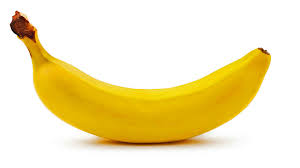

In [186]:
path = 'banana.jpeg'
display(I_note(path, width=400, height=400))

In [187]:
seed,sentence = caption(path)
print(sentence)

memes STOP STOP STOP cost STOP this STOP i say true STOP


# BLEU evaluation

In [188]:
seed,sentences = multi_caption(path)
print(sentences)

['memes STOP STOP STOP cost STOP this STOP i say true STOP', 'STOP i put pretty news STOP STOP STOP STOP STOP my hero', 'STOP i would be lemon STOP and a fluffy pc STOP STOP', 'STOP is work STOP STOP STOP this is time STOP i get', 'STOP STOP this good high that getting time STOP i probably captured']


In [191]:
def calculate_bleu(path):
    seed,sentences = multi_caption(path)
    in_filename = 'LangModel2/captions.txt'
    reference = [line.split() for line in load_doc(in_filename).splitlines()]

    return corpus_bleu([reference for _ in range(len(sentences))], [s.split() for s in sentences])

In [192]:
calculate_bleu(path)
print(score)

0.6779219713470268


/Users/admin/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [193]:
paths = ['banana.jpeg','thanos.png','spongebob.jpg','steve.jpg','superbowl.jpeg','zuck.jpg','doge.jpg','flatirons.jpg','onesimply.jpg']
scores = [calculate_bleu(p) for p in paths]

/Users/admin/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/Users/admin/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [200]:
print('AVG: %s ±%s' % (np.average(scores),np.std(scores)))

AVG: 0.3538443220191876 ±0.1988791713797418
